In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel


from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor

from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [2]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [3]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
# cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
#           'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']

cities = [ 'Bình Phước', 'An Giang','Quảng Ninh']

In [4]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [5]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [6]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [7]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [8]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [9]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [10]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [11]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y)

In [12]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

    df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    model.fit(y_train, past_covariates = x_train)

    prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

    df_eval = df_eval[-args.test_size:]
    y_true = df_eval[labels].values
    df_eval[labels]= np.array(prediction._xa).squeeze()
    y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"mean_squared_error: {mse:.4f}")
    print(f"rmse: {rmse}")
    print(f"mape: {mape}")
    return model, y_true, y_pred, mse, mae, rmse, mape

In [13]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':prediction_inverse})
    df_compare_test_predict.plot()
    plt.legend()
    plt.title(f"{nstep}step_{type(model).__name__}_DF_{location}")
    plt.savefig(f"./predict_results/{nstep}step_{type(model).__name__}_DF_{location}_tkde.png", dpi=300)
    plt.show()

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [14]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv", encoding = 'unicode_escape')
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [15]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

In [16]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.408189,1,3,"-1,-2,-3",1,179,10,15
1,An Giang,RandomForest,13.822933,1,3,"-1,-2,-3",1,50,7,13
2,Quảng Ninh,RandomForest,5.497918,1,3,"-1,-2,-3",1,112,15,24


mean_squared_error: 364.3973
rmse: 19.089193949963217
mape: 3.43716487807977


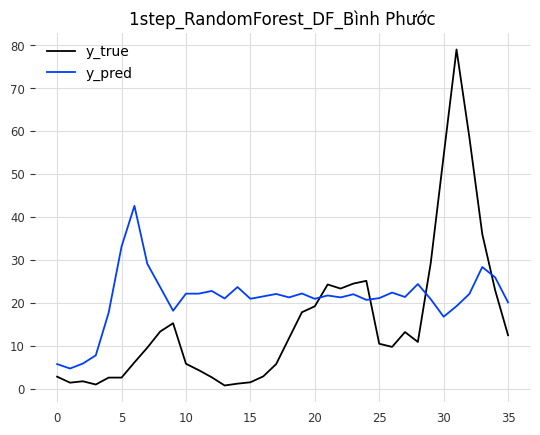

rmse,mae,mape,mse
19.089193949963217,14.32146659868449,3.43716487807977,364.39732565931234
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.408189,1,3,"-1,-2,-3",1,179,10,15
1,An Giang,RandomForest,13.822933,1,3,"-1,-2,-3",1,50,7,13
2,Quảng Ninh,RandomForest,5.497918,1,3,"-1,-2,-3",1,112,15,24


mean_squared_error: 254.8238
rmse: 15.963199898474459
mape: 1.9782745488170113


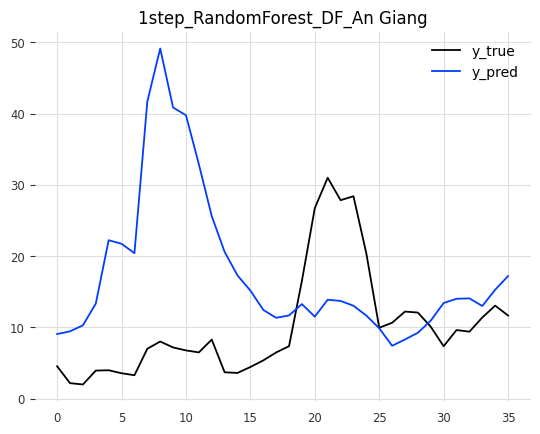

rmse,mae,mape,mse
15.963199898474459,12.108794953233065,1.9782745488170113,254.82375099865496
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.408189,1,3,"-1,-2,-3",1,179,10,15
1,An Giang,RandomForest,13.822933,1,3,"-1,-2,-3",1,50,7,13
2,Quảng Ninh,RandomForest,5.497918,1,3,"-1,-2,-3",1,112,15,24


mean_squared_error: 28.0390
rmse: 5.2951891492147665
mape: 2154884656434917.8


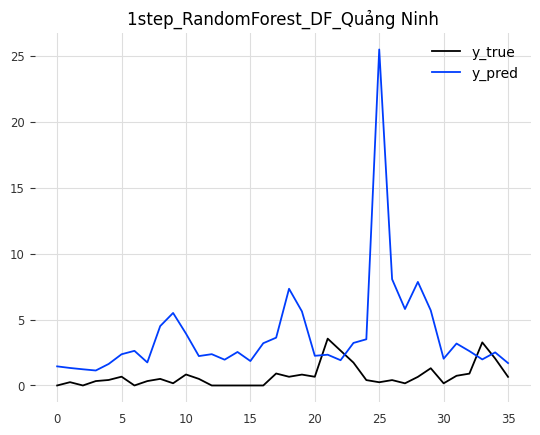

rmse,mae,mape,mse
5.2951891492147665,3.2999658507650866,2154884656434917.8,28.0390281259618
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.212830,1,3,"-1,-2,-3",1,2
1,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,19
2,Quảng Ninh,LinearRegressionModel,2.000619,1,3,"-1,-2,-3",1,40


mean_squared_error: 360.4788
rmse: 18.986278536765678
mape: 4.583430317192895


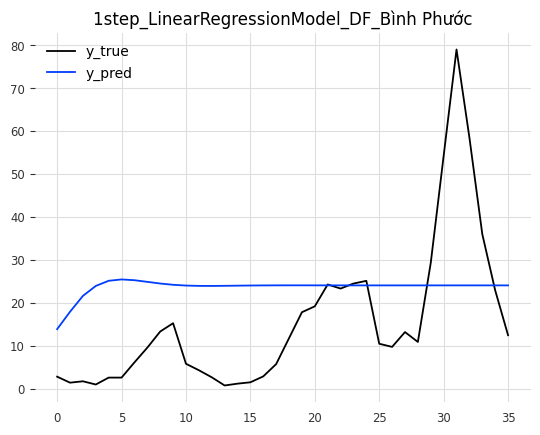

rmse,mae,mape,mse
18.986278536765678,15.682272706444792,4.583430317192895,360.478772675649
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.212830,1,3,"-1,-2,-3",1,2
1,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,19
2,Quảng Ninh,LinearRegressionModel,2.000619,1,3,"-1,-2,-3",1,40


mean_squared_error: 184.7688
rmse: 13.592970349615078
mape: 1.864611516690918


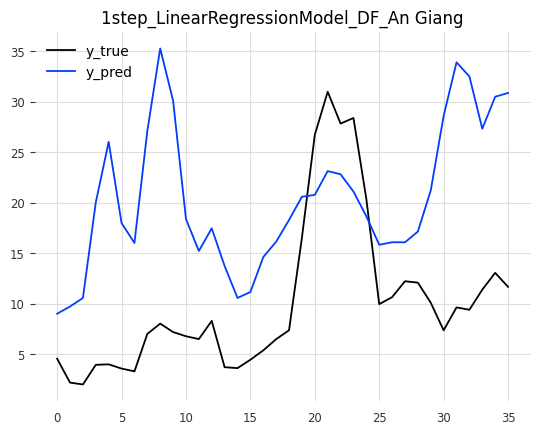

rmse,mae,mape,mse
13.592970349615078,11.768939375892574,1.864611516690918,184.76884292551466
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.212830,1,3,"-1,-2,-3",1,2
1,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,19
2,Quảng Ninh,LinearRegressionModel,2.000619,1,3,"-1,-2,-3",1,40


mean_squared_error: 2.6080
rmse: 1.6149231667834658
mape: 2051544880003710.2


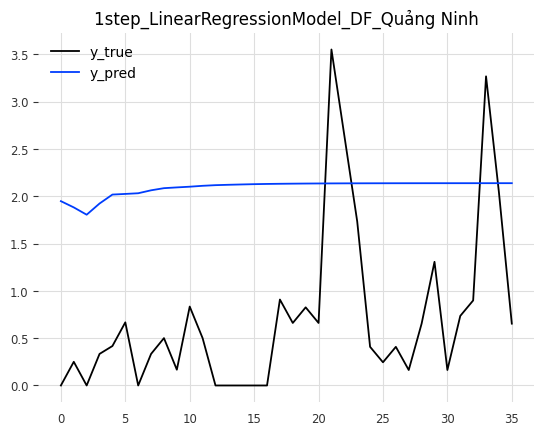

rmse,mae,mape,mse
1.6149231667834658,1.5402763046524406,2051544880003710.2,2.607976834613938
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,20.241153,1,3,"-1,-2,-3",1,0.003825,78,11,165,quantile,IsNone,34.516778,51,7.628785,3.844560
1,An Giang,CatBoost,19.467369,1,3,"-1,-2,-3",1,0.069832,172,7,408,quantile,IsNone,59.261031,3,2.118456,5.602066
2,Quảng Ninh,CatBoost,1.366177,1,3,"-1,-2,-3",1,0.017348,88,4,902,quantile,IsNone,79.692209,29,3.953189,3.277713


mean_squared_error: 307.2006
rmse: 17.52713947008833
mape: 2.6282691227954214


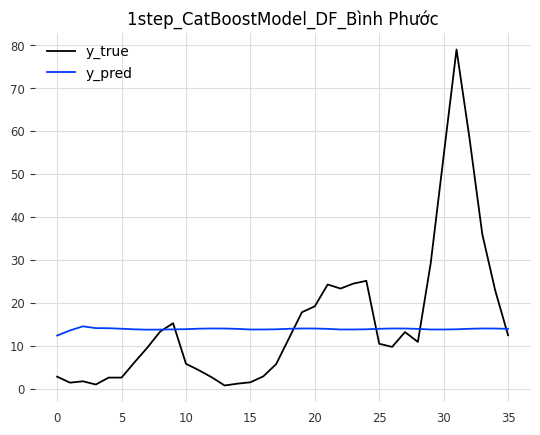

rmse,mae,mape,mse
17.52713947008833,12.030717558493633,2.6282691227954214,307.20061800392824
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,20.241153,1,3,"-1,-2,-3",1,0.003825,78,11,165,quantile,IsNone,34.516778,51,7.628785,3.844560
1,An Giang,CatBoost,19.467369,1,3,"-1,-2,-3",1,0.069832,172,7,408,quantile,IsNone,59.261031,3,2.118456,5.602066
2,Quảng Ninh,CatBoost,1.366177,1,3,"-1,-2,-3",1,0.017348,88,4,902,quantile,IsNone,79.692209,29,3.953189,3.277713


mean_squared_error: 112.9456
rmse: 10.627586726395794
mape: 1.456499687122607


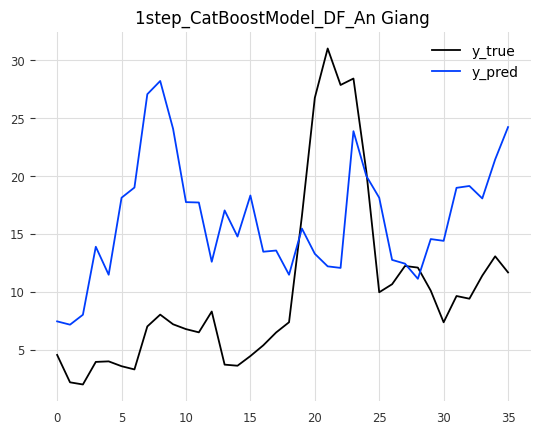

rmse,mae,mape,mse
10.627586726395794,9.063414588486458,1.456499687122607,112.94559962706406
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,20.241153,1,3,"-1,-2,-3",1,0.003825,78,11,165,quantile,IsNone,34.516778,51,7.628785,3.844560
1,An Giang,CatBoost,19.467369,1,3,"-1,-2,-3",1,0.069832,172,7,408,quantile,IsNone,59.261031,3,2.118456,5.602066
2,Quảng Ninh,CatBoost,1.366177,1,3,"-1,-2,-3",1,0.017348,88,4,902,quantile,IsNone,79.692209,29,3.953189,3.277713


mean_squared_error: 0.9708
rmse: 0.9852971546711506
mape: 1169525112858579.8


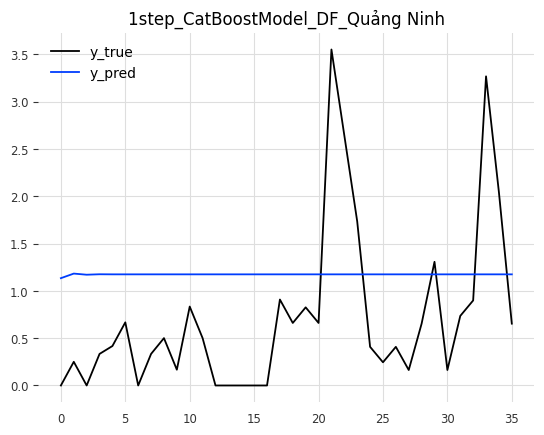

rmse,mae,mape,mse
0.9852971546711506,0.8694107092784418,1169525112858579.8,0.9708104830030653
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.151823,1,3,"-1,-2,-3",1,10,quantile
1,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,31,quantile
2,Quảng Ninh,XGBModel,4.251057,1,3,"-1,-2,-3",1,38,quantile


mean_squared_error: 7817.2138
rmse: 88.41500875671214
mape: 16.000676860581297


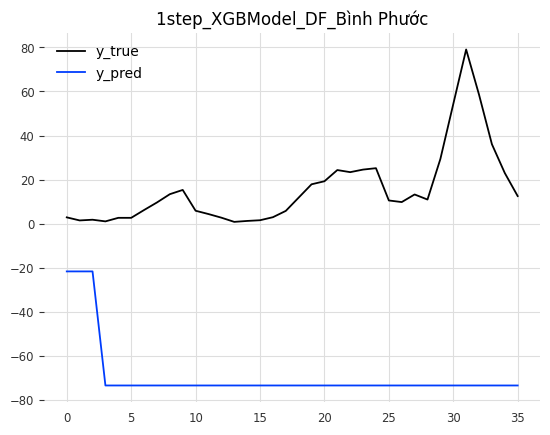

rmse,mae,mape,mse
88.41500875671214,84.79785401662483,16.000676860581297,7817.213773449485
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.151823,1,3,"-1,-2,-3",1,10,quantile
1,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,31,quantile
2,Quảng Ninh,XGBModel,4.251057,1,3,"-1,-2,-3",1,38,quantile


mean_squared_error: 1052.6362
rmse: 32.44435536364024
mape: 3.831969991196966


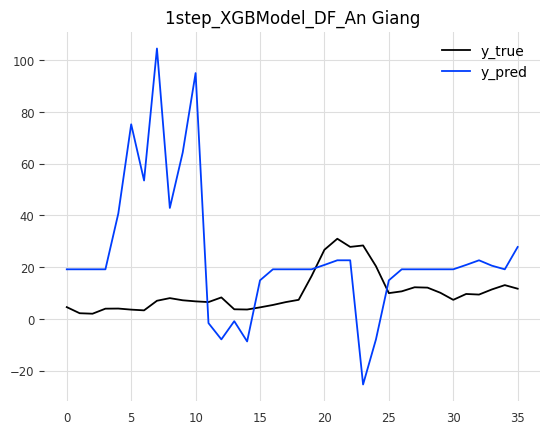

rmse,mae,mape,mse
32.44435536364024,22.199818214297075,3.831969991196966,1052.6361949621712
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.151823,1,3,"-1,-2,-3",1,10,quantile
1,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,31,quantile
2,Quảng Ninh,XGBModel,4.251057,1,3,"-1,-2,-3",1,38,quantile


mean_squared_error: 27.8158
rmse: 5.274066675764937
mape: 4310584193944713.0


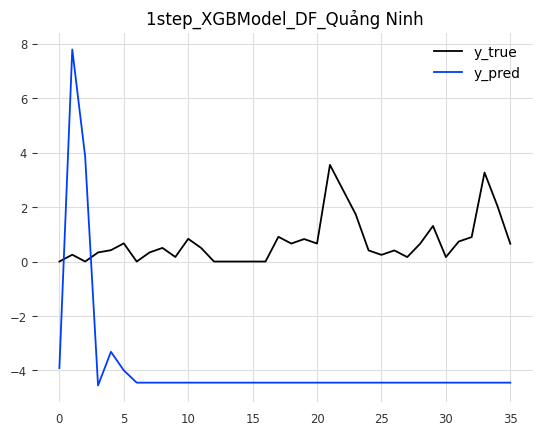

rmse,mae,mape,mse
5.274066675764937,5.1746021399809585,4310584193944713.0,27.81577930041421
✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.410701,1,4,"-2,-3,-4",1,128,2,15
1,An Giang,RandomForest,7.983549,1,4,"-2,-3,-4",1,94,1,31
2,Quảng Ninh,RandomForest,4.597111,1,4,"-2,-3,-4",1,177,12,30


mean_squared_error: 344.5470
rmse: 18.561977726237615
mape: 1.7496161689547376


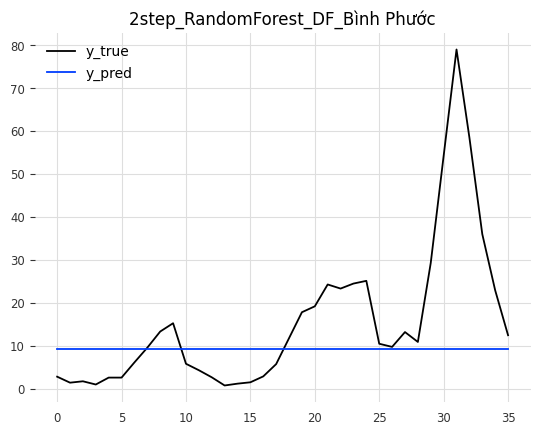

rmse,mae,mape,mse
18.561977726237615,11.714066877079103,1.7496161689547376,344.54701710934137
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.410701,1,4,"-2,-3,-4",1,128,2,15
1,An Giang,RandomForest,7.983549,1,4,"-2,-3,-4",1,94,1,31
2,Quảng Ninh,RandomForest,4.597111,1,4,"-2,-3,-4",1,177,12,30


mean_squared_error: 69.1499
rmse: 8.315640210687977
mape: 1.2774891743516228


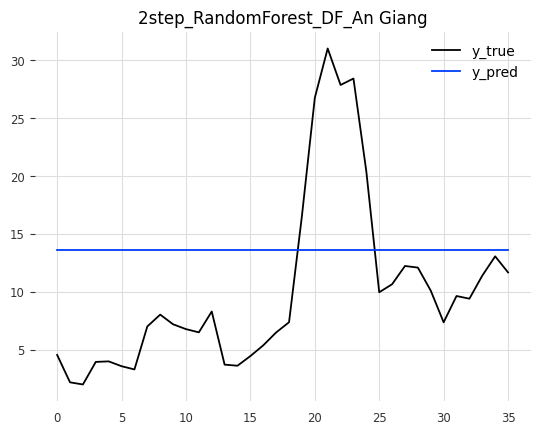

rmse,mae,mape,mse
8.315640210687977,7.26108770793643,1.2774891743516228,69.14987211361078
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.410701,1,4,"-2,-3,-4",1,128,2,15
1,An Giang,RandomForest,7.983549,1,4,"-2,-3,-4",1,94,1,31
2,Quảng Ninh,RandomForest,4.597111,1,4,"-2,-3,-4",1,177,12,30


mean_squared_error: 17.3017
rmse: 4.159534950377385
mape: 4227265679117495.0


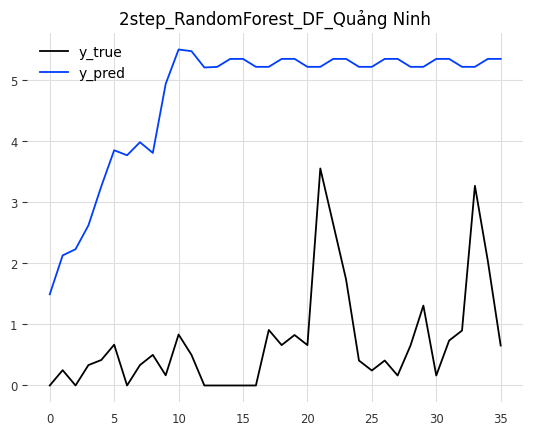

rmse,mae,mape,mse
4.159534950377385,3.9921024879062603,4227265679117495.0,17.30173100341099
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.141685,1,4,"-2,-3,-4",1,12
1,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,35
2,Quảng Ninh,LinearRegressionModel,2.028822,1,4,"-2,-3,-4",1,33


mean_squared_error: 365.0648
rmse: 19.106669641292232
mape: 4.604454741099784


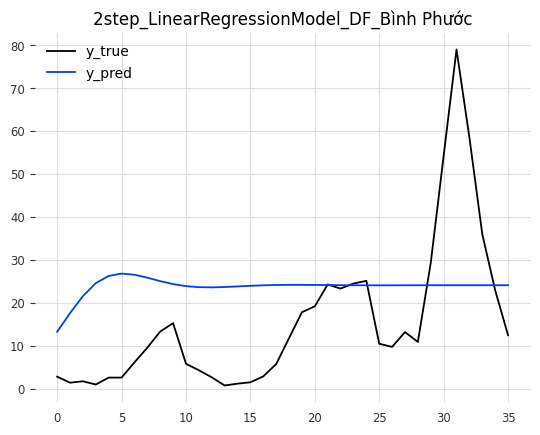

rmse,mae,mape,mse
19.106669641292232,15.79762165763864,4.604454741099784,365.0648247814782
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.141685,1,4,"-2,-3,-4",1,12
1,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,35
2,Quảng Ninh,LinearRegressionModel,2.028822,1,4,"-2,-3,-4",1,33


mean_squared_error: 195.5684
rmse: 13.984577150904904
mape: 2.0226315379199753


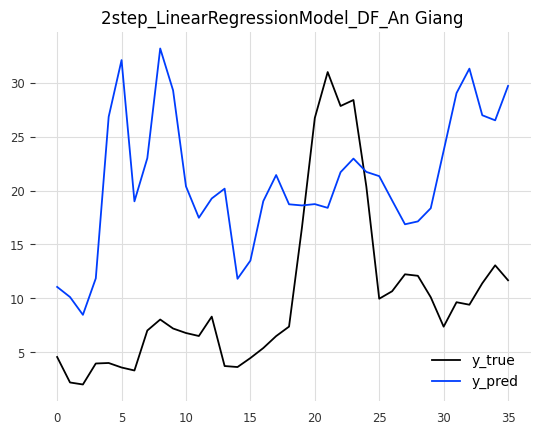

rmse,mae,mape,mse
13.984577150904904,12.402518518473059,2.0226315379199753,195.56839808961155
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.141685,1,4,"-2,-3,-4",1,12
1,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,35
2,Quảng Ninh,LinearRegressionModel,2.028822,1,4,"-2,-3,-4",1,33


mean_squared_error: 2.5788
rmse: 1.605855240210963
mape: 2039523305312493.2


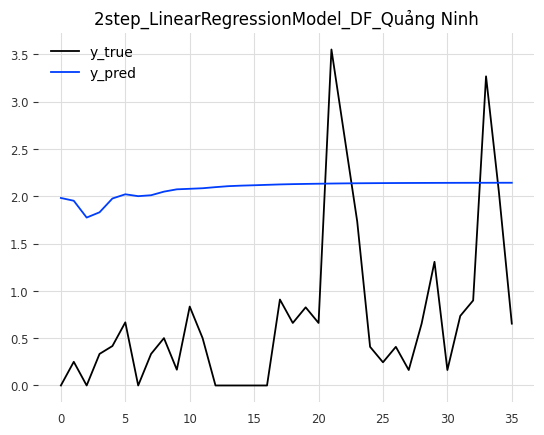

rmse,mae,mape,mse
1.605855240210963,1.5317770638260324,2039523305312493.2,2.5787710525130096
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,20.138328,1,4,"-2,-3,-4",1,0.040616,71,11,146,quantile,"0.1,0.5,0.9",14.816427,206,5.082537,2.147843
1,An Giang,CatBoost,8.166875,1,4,"-2,-3,-4",1,0.093134,131,1,872,quantile,IsNone,40.183041,23,9.870739,9.165289
2,Quảng Ninh,CatBoost,5.994503,1,4,"-2,-3,-4",1,0.078782,120,3,287,quantile,IsNone,65.949184,226,6.771307,6.550317


🔥 0    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 327.5022
rmse: 18.09702056813444
mape: 1.9639661435564777


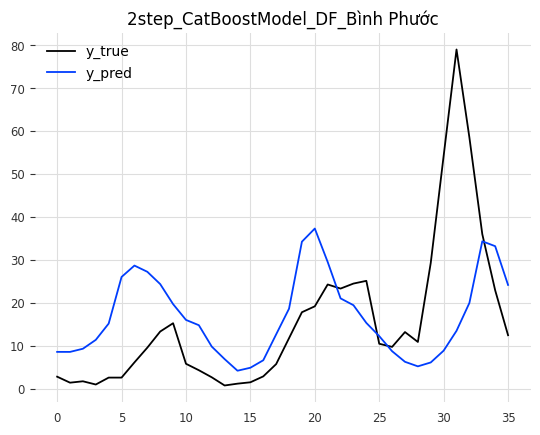

rmse,mae,mape,mse
18.09702056813444,12.466901688602741,1.9639661435564777,327.502153443481
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,20.138328,1,4,"-2,-3,-4",1,0.040616,71,11,146,quantile,"0.1,0.5,0.9",14.816427,206,5.082537,2.147843
1,An Giang,CatBoost,8.166875,1,4,"-2,-3,-4",1,0.093134,131,1,872,quantile,IsNone,40.183041,23,9.870739,9.165289
2,Quảng Ninh,CatBoost,5.994503,1,4,"-2,-3,-4",1,0.078782,120,3,287,quantile,IsNone,65.949184,226,6.771307,6.550317


mean_squared_error: 57.4318
rmse: 7.578380424818507
mape: 0.6585133592623725


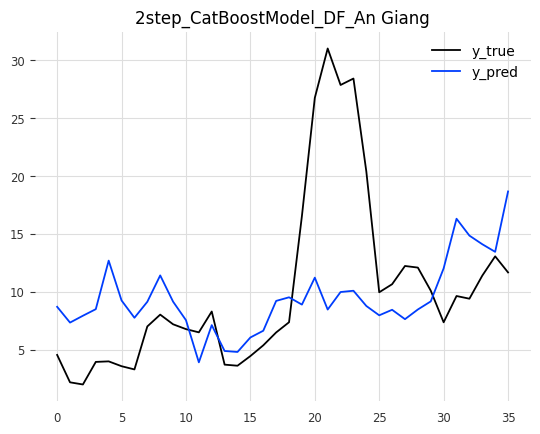

rmse,mae,mape,mse
7.578380424818507,5.4003016361543414,0.6585133592623725,57.43184986327233
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,20.138328,1,4,"-2,-3,-4",1,0.040616,71,11,146,quantile,"0.1,0.5,0.9",14.816427,206,5.082537,2.147843
1,An Giang,CatBoost,8.166875,1,4,"-2,-3,-4",1,0.093134,131,1,872,quantile,IsNone,40.183041,23,9.870739,9.165289
2,Quảng Ninh,CatBoost,5.994503,1,4,"-2,-3,-4",1,0.078782,120,3,287,quantile,IsNone,65.949184,226,6.771307,6.550317


mean_squared_error: 2.0180
rmse: 1.4205532414922037
mape: 1822277065852274.8


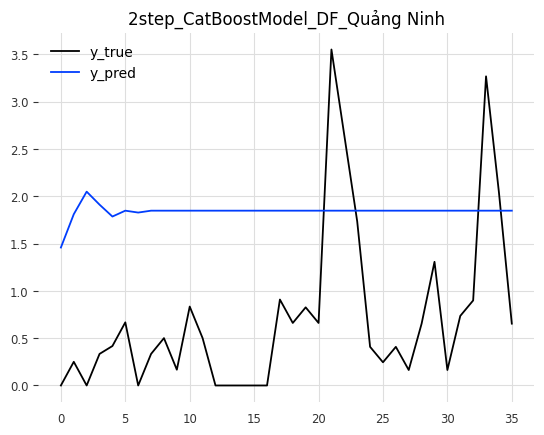

rmse,mae,mape,mse
1.4205532414922037,1.3484164364723945,1822277065852274.8,2.0179715119140074
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.233398,1,4,"-2,-3,-4",1,40,quantile
1,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,30,quantile
2,Quảng Ninh,XGBModel,5.264404,1,4,"-2,-3,-4",1,33,quantile


mean_squared_error: 7889.9553
rmse: 88.82542053857507
mape: 14.831577724006273


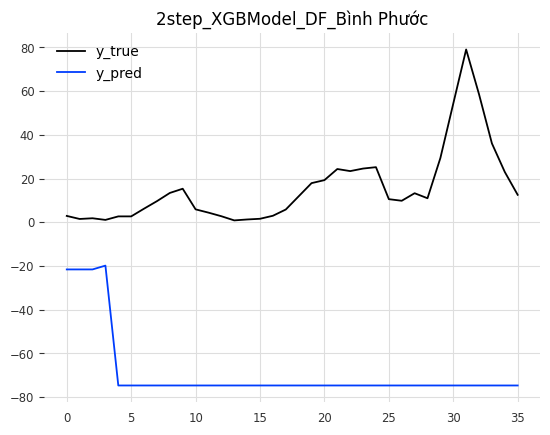

rmse,mae,mape,mse
88.82542053857507,84.48100430721989,14.831577724006273,7889.955333854716
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.233398,1,4,"-2,-3,-4",1,40,quantile
1,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,30,quantile
2,Quảng Ninh,XGBModel,5.264404,1,4,"-2,-3,-4",1,33,quantile


mean_squared_error: 1916.6461
rmse: 43.77951661911574
mape: 6.443460109785577


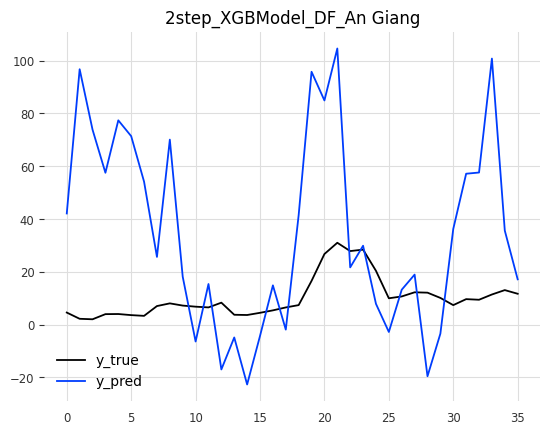

rmse,mae,mape,mse
43.77951661911574,34.02859574003378,6.443460109785577,1916.646075403431
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.233398,1,4,"-2,-3,-4",1,40,quantile
1,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,30,quantile
2,Quảng Ninh,XGBModel,5.264404,1,4,"-2,-3,-4",1,33,quantile


mean_squared_error: 26.5637
rmse: 5.1539989517538976
mape: 4253937023131266.0


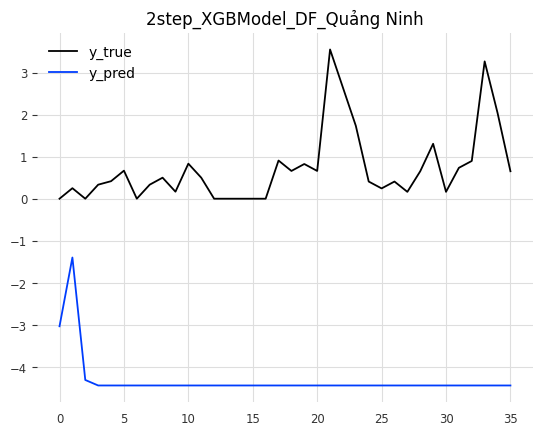

rmse,mae,mape,mse
5.1539989517538976,5.035750117626775,4253937023131266.0,26.56370519468027
✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,19.665466,1,5,"-3,-4,-5",1,176,6,34
1,An Giang,RandomForest,8.580549,1,5,"-3,-4,-5",1,98,4,15
2,Quảng Ninh,RandomForest,5.792956,1,5,"-3,-4,-5",1,109,8,32


mean_squared_error: 348.8007
rmse: 18.67620619377836
mape: 3.550014817911466


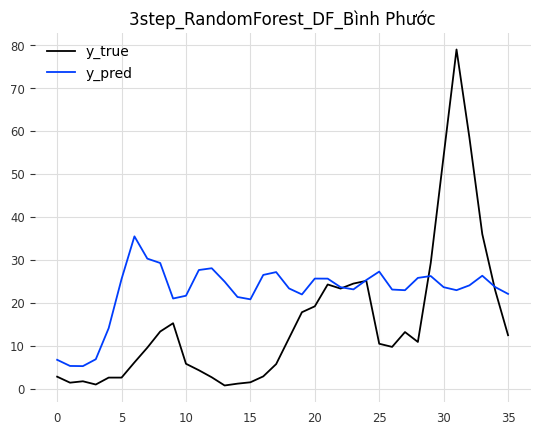

rmse,mae,mape,mse
18.67620619377836,14.469672680616355,3.550014817911466,348.80067779252516
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,19.665466,1,5,"-3,-4,-5",1,176,6,34
1,An Giang,RandomForest,8.580549,1,5,"-3,-4,-5",1,98,4,15
2,Quảng Ninh,RandomForest,5.792956,1,5,"-3,-4,-5",1,109,8,32


mean_squared_error: 73.7088
rmse: 8.585381037589238
mape: 1.1185965894347172


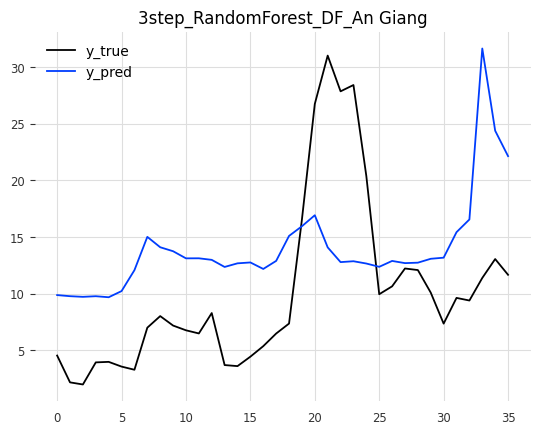

rmse,mae,mape,mse
8.585381037589238,7.446260357688508,1.1185965894347172,73.70876756059687
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,19.665466,1,5,"-3,-4,-5",1,176,6,34
1,An Giang,RandomForest,8.580549,1,5,"-3,-4,-5",1,98,4,15
2,Quảng Ninh,RandomForest,5.792956,1,5,"-3,-4,-5",1,109,8,32


mean_squared_error: 1.3205
rmse: 1.1491364599741671
mape: 1372123466917433.8


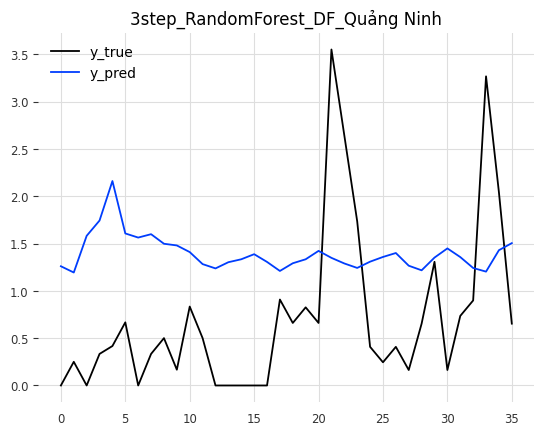

rmse,mae,mape,mse
1.1491364599741671,1.0465013744775922,1372123466917433.8,1.3205146036419606
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.159680,1,5,"-3,-4,-5",1,24
1,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,3
2,Quảng Ninh,LinearRegressionModel,2.021787,1,5,"-3,-4,-5",1,7


mean_squared_error: 360.5429
rmse: 18.98796592969123
mape: 4.581021102193168


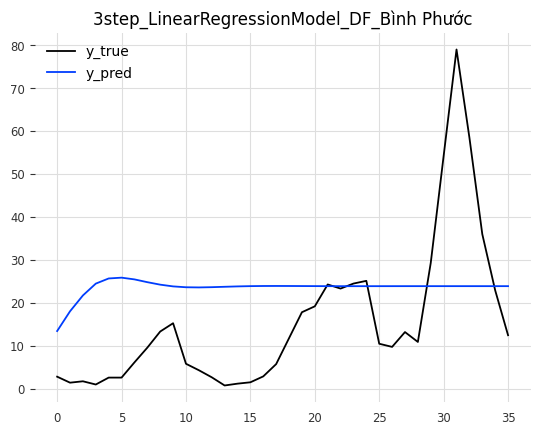

rmse,mae,mape,mse
18.98796592969123,15.642306088130292,4.581021102193168,360.54285014711496
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.159680,1,5,"-3,-4,-5",1,24
1,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,3
2,Quảng Ninh,LinearRegressionModel,2.021787,1,5,"-3,-4,-5",1,7


mean_squared_error: 152.3325
rmse: 12.342304492031591
mape: 1.788989555655957


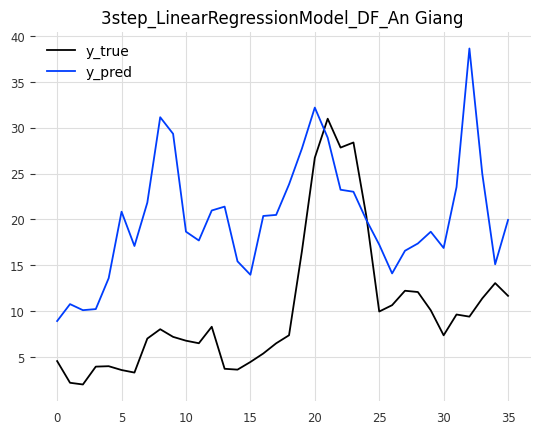

rmse,mae,mape,mse
12.342304492031591,10.645827807948233,1.788989555655957,152.3324801740232
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.159680,1,5,"-3,-4,-5",1,24
1,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,3
2,Quảng Ninh,LinearRegressionModel,2.021787,1,5,"-3,-4,-5",1,7


mean_squared_error: 2.5745
rmse: 1.604531802756072
mape: 2038507610243985.0


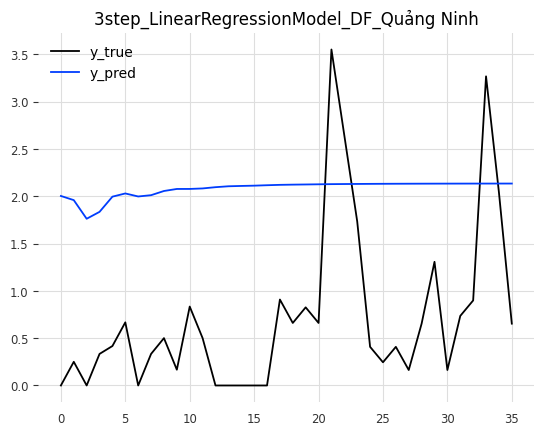

rmse,mae,mape,mse
1.604531802756072,1.5302171605208281,2038507610243985.0,2.57452230605565
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,23.241107,1,5,"-3,-4,-5",1,0.040690,200,2,226,quantile,"0.1,0.5,0.9",50.915021,218,0.285424,5.310459
1,An Giang,CatBoost,8.140771,1,5,"-3,-4,-5",1,0.077838,138,1,977,quantile,IsNone,83.859533,239,6.063218,7.018288
2,Quảng Ninh,CatBoost,4.736654,1,5,"-3,-4,-5",1,0.022799,176,13,28,quantile,"0.1,0.5,0.9",61.438903,42,5.622812,1.513493


🔥 0    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 376.4222
rmse: 19.401603090913603
mape: 1.8232246181363492


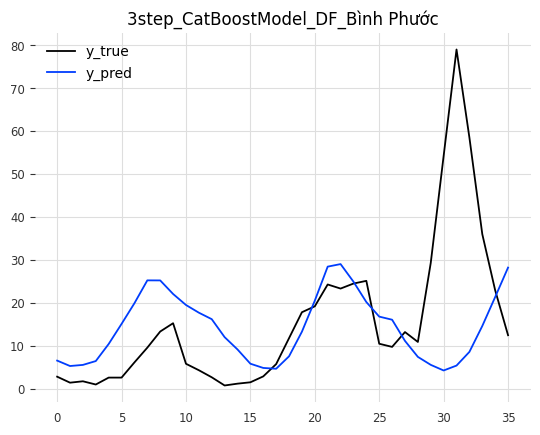

rmse,mae,mape,mse
19.401603090913603,11.994240020243065,1.8232246181363492,376.4222024973483
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,23.241107,1,5,"-3,-4,-5",1,0.040690,200,2,226,quantile,"0.1,0.5,0.9",50.915021,218,0.285424,5.310459
1,An Giang,CatBoost,8.140771,1,5,"-3,-4,-5",1,0.077838,138,1,977,quantile,IsNone,83.859533,239,6.063218,7.018288
2,Quảng Ninh,CatBoost,4.736654,1,5,"-3,-4,-5",1,0.022799,176,13,28,quantile,"0.1,0.5,0.9",61.438903,42,5.622812,1.513493


mean_squared_error: 57.6482
rmse: 7.592641062567963
mape: 0.9498251914675938


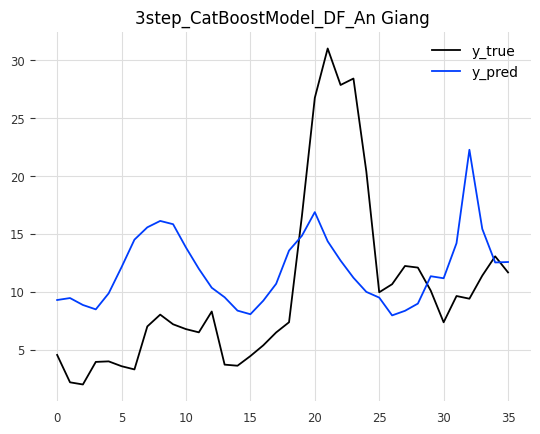

rmse,mae,mape,mse
7.592641062567963,6.286537189236073,0.9498251914675938,57.648198304993166
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,23.241107,1,5,"-3,-4,-5",1,0.040690,200,2,226,quantile,"0.1,0.5,0.9",50.915021,218,0.285424,5.310459
1,An Giang,CatBoost,8.140771,1,5,"-3,-4,-5",1,0.077838,138,1,977,quantile,IsNone,83.859533,239,6.063218,7.018288
2,Quảng Ninh,CatBoost,4.736654,1,5,"-3,-4,-5",1,0.022799,176,13,28,quantile,"0.1,0.5,0.9",61.438903,42,5.622812,1.513493


🔥 2    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 2.3418
rmse: 1.530309792175173
mape: 1938061948071501.2


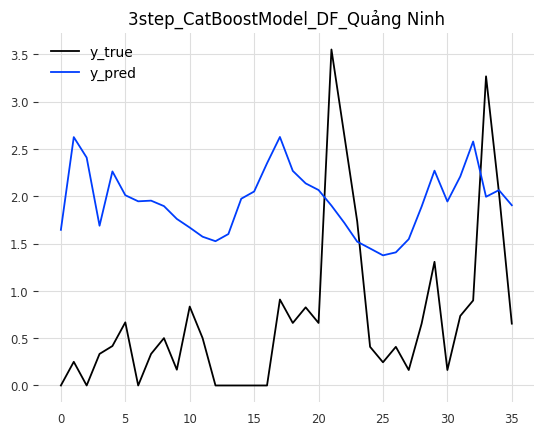

rmse,mae,mape,mse
1.530309792175173,1.4437615257802798,1938061948071501.2,2.341848060027221
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.390515,1,5,"-3,-4,-5",1,11,quantile
1,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,1,quantile
2,Quảng Ninh,XGBModel,12.996125,1,5,"-3,-4,-5",1,6,quantile


mean_squared_error: 1628.4584
rmse: 40.35416228463758
mape: 5.882025069138938


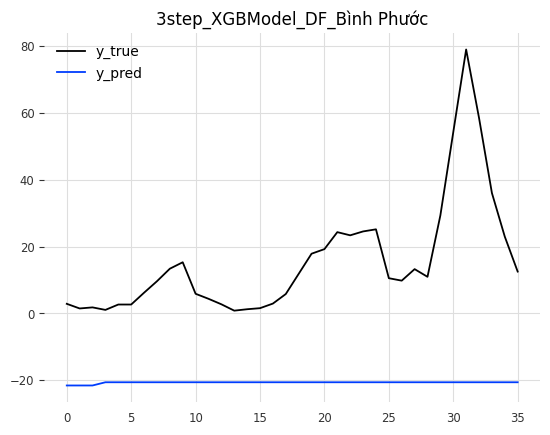

rmse,mae,mape,mse
40.35416228463758,36.42064272796193,5.882025069138938,1628.4584136948663
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.390515,1,5,"-3,-4,-5",1,11,quantile
1,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,1,quantile
2,Quảng Ninh,XGBModel,12.996125,1,5,"-3,-4,-5",1,6,quantile


mean_squared_error: 1994.4614
rmse: 44.65939283012492
mape: 5.7112491528461184


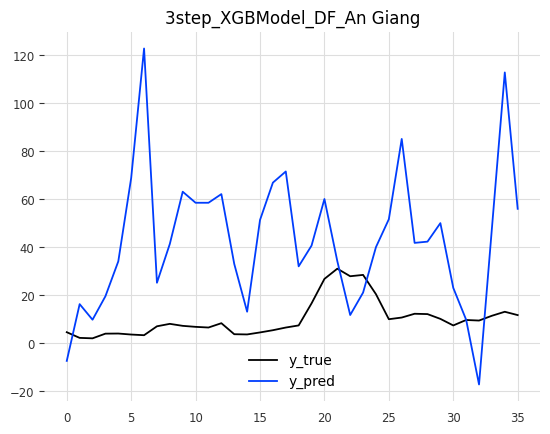

rmse,mae,mape,mse
44.65939283012492,36.3044755885307,5.7112491528461184,1994.4613679554136
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.390515,1,5,"-3,-4,-5",1,11,quantile
1,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,1,quantile
2,Quảng Ninh,XGBModel,12.996125,1,5,"-3,-4,-5",1,6,quantile


mean_squared_error: 16.1411
rmse: 4.017597758543321
mape: 2964194696701972.5


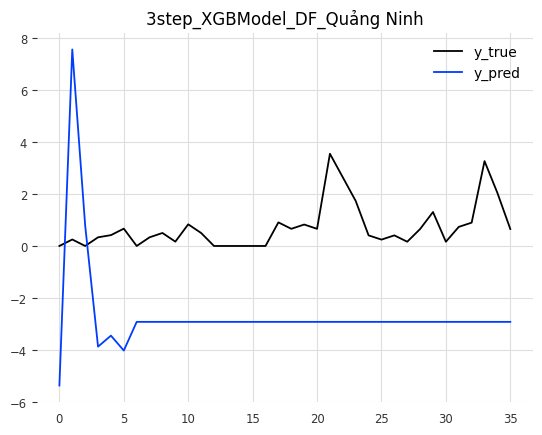

rmse,mae,mape,mse
4.017597758543321,3.837917774132011,2964194696701972.5,16.141091749452315
✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.813981,1,6,"-4,-5,-6",1,126,13,12
1,An Giang,RandomForest,8.820885,1,6,"-4,-5,-6",1,125,6,29
2,Quảng Ninh,RandomForest,8.083532,1,6,"-4,-5,-6",1,174,2,31


mean_squared_error: 475.2146
rmse: 21.799418441606164
mape: 5.05866020922625


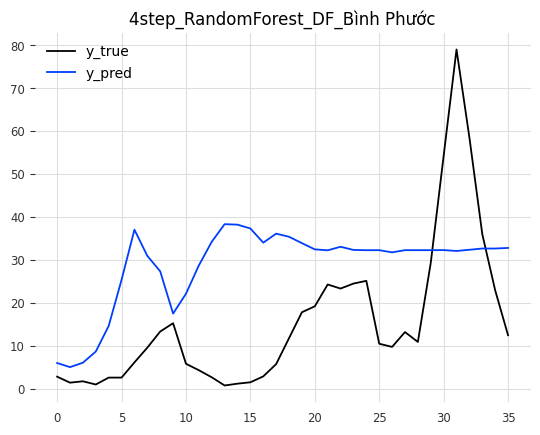

rmse,mae,mape,mse
21.799418441606164,18.532219605587827,5.05866020922625,475.2146443922389
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.813981,1,6,"-4,-5,-6",1,126,13,12
1,An Giang,RandomForest,8.820885,1,6,"-4,-5,-6",1,125,6,29
2,Quảng Ninh,RandomForest,8.083532,1,6,"-4,-5,-6",1,174,2,31


mean_squared_error: 176.1512
rmse: 13.272194909408771
mape: 1.9889104580979127


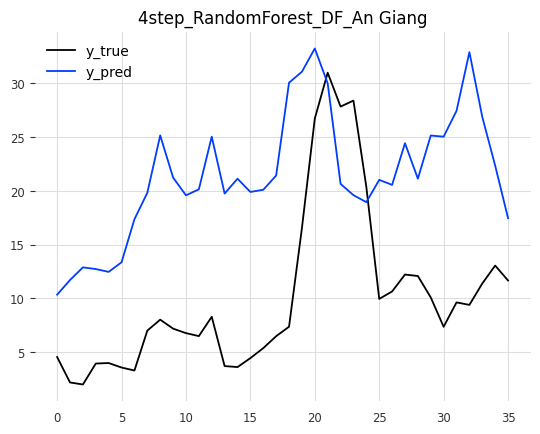

rmse,mae,mape,mse
13.272194909408771,12.289260728294984,1.9889104580979127,176.15115771333612
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.813981,1,6,"-4,-5,-6",1,126,13,12
1,An Giang,RandomForest,8.820885,1,6,"-4,-5,-6",1,125,6,29
2,Quảng Ninh,RandomForest,8.083532,1,6,"-4,-5,-6",1,174,2,31


mean_squared_error: 5.1532
rmse: 2.2700630569805424
mape: 2720116928932702.0


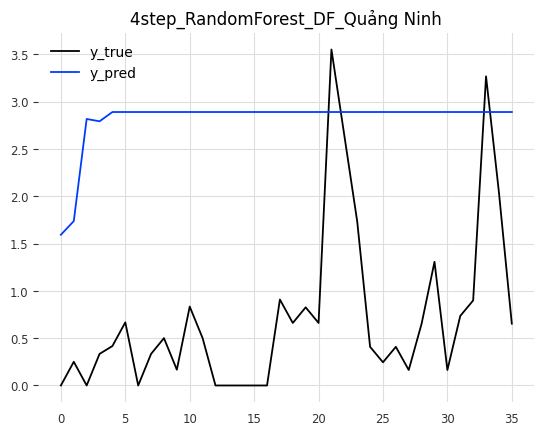

rmse,mae,mape,mse
2.2700630569805424,2.1539423711169294,2720116928932702.0,5.1531862826678445
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.152942,1,6,"-4,-5,-6",1,22
1,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,24
2,Quảng Ninh,LinearRegressionModel,2.005737,1,6,"-4,-5,-6",1,5


mean_squared_error: 355.0102
rmse: 18.841714443075087
mape: 4.468460924615873


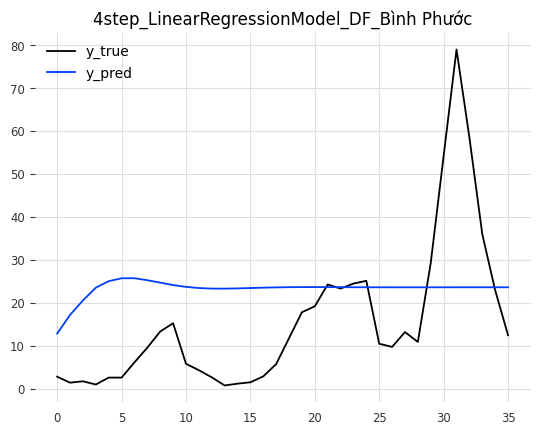

rmse,mae,mape,mse
18.841714443075087,15.481003019871991,4.468460924615873,355.0102031543844
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.152942,1,6,"-4,-5,-6",1,22
1,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,24
2,Quảng Ninh,LinearRegressionModel,2.005737,1,6,"-4,-5,-6",1,5


mean_squared_error: 110.1778
rmse: 10.496559853154205
mape: 1.5245214216082605


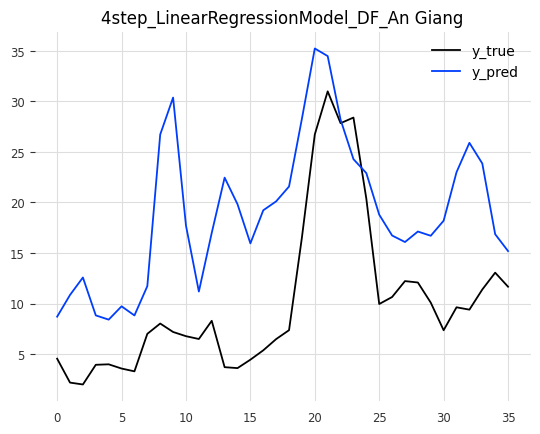

rmse,mae,mape,mse
10.496559853154205,9.033686158145969,1.5245214216082605,110.17776875084863
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,20.152942,1,6,"-4,-5,-6",1,22
1,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,24
2,Quảng Ninh,LinearRegressionModel,2.005737,1,6,"-4,-5,-6",1,5


mean_squared_error: 2.5556
rmse: 1.598631615471317
mape: 2035425913029749.2


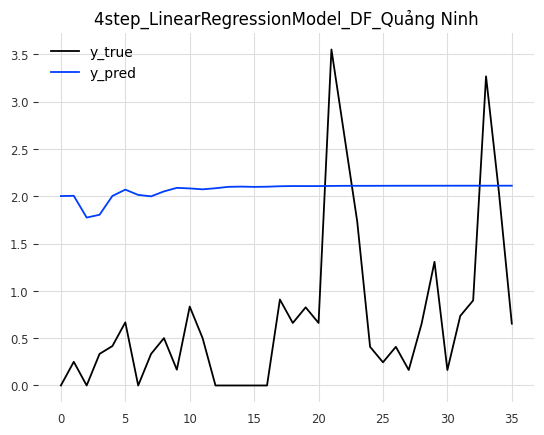

rmse,mae,mape,mse
1.598631615471317,1.5237129522144583,2035425913029749.2,2.5556230419844326
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,21.060364,1,6,"-4,-5,-6",1,0.092890,157,2,608,quantile,"0.1,0.5,0.9",47.034011,183,2.724005,2.664207
1,An Giang,CatBoost,9.595715,1,6,"-4,-5,-6",1,0.023991,105,7,182,quantile,"0.1,0.5,0.9",99.863295,173,0.620815,4.525385
2,Quảng Ninh,CatBoost,3.086327,1,6,"-4,-5,-6",1,0.039749,109,10,11,quantile,"0.1,0.5,0.9",38.288557,159,0.200867,8.187055


🔥 0    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 277.4579
rmse: 16.657066168509512
mape: 2.930143751014896


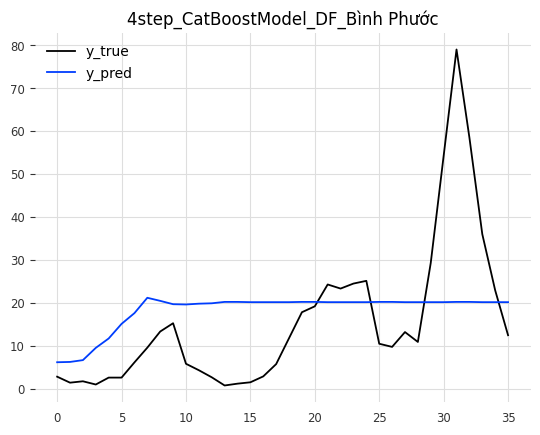

rmse,mae,mape,mse
16.657066168509512,12.346564387835224,2.930143751014896,277.45785334210416
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,21.060364,1,6,"-4,-5,-6",1,0.092890,157,2,608,quantile,"0.1,0.5,0.9",47.034011,183,2.724005,2.664207
1,An Giang,CatBoost,9.595715,1,6,"-4,-5,-6",1,0.023991,105,7,182,quantile,"0.1,0.5,0.9",99.863295,173,0.620815,4.525385
2,Quảng Ninh,CatBoost,3.086327,1,6,"-4,-5,-6",1,0.039749,109,10,11,quantile,"0.1,0.5,0.9",38.288557,159,0.200867,8.187055


🔥 1    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 53.2659
rmse: 7.298348502942582
mape: 1.1639873670105843


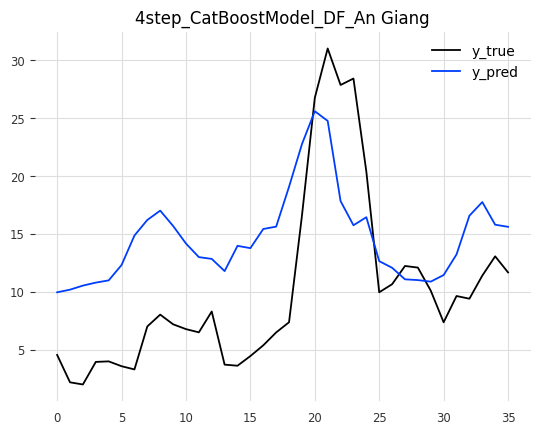

rmse,mae,mape,mse
7.298348502942582,6.5258134326098745,1.1639873670105843,53.26589087040422
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,21.060364,1,6,"-4,-5,-6",1,0.092890,157,2,608,quantile,"0.1,0.5,0.9",47.034011,183,2.724005,2.664207
1,An Giang,CatBoost,9.595715,1,6,"-4,-5,-6",1,0.023991,105,7,182,quantile,"0.1,0.5,0.9",99.863295,173,0.620815,4.525385
2,Quảng Ninh,CatBoost,3.086327,1,6,"-4,-5,-6",1,0.039749,109,10,11,quantile,"0.1,0.5,0.9",38.288557,159,0.200867,8.187055


🔥 2    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 30.2311
rmse: 5.498277156798484
mape: 5734702549513429.0


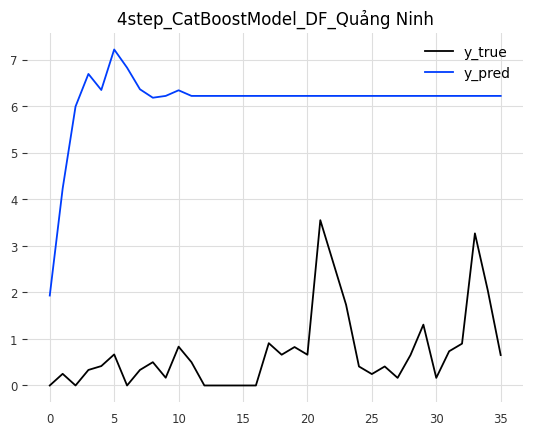

rmse,mae,mape,mse
5.498277156798484,5.385216220763059,5734702549513429.0,30.231051692972024
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,41.036587,1,6,"-4,-5,-6",1,14,quantile
1,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,37,quantile
2,Quảng Ninh,XGBModel,6.602554,1,6,"-4,-5,-6",1,3,quantile


mean_squared_error: 1629.2508
rmse: 40.36397902219954
mape: 5.884581441026143


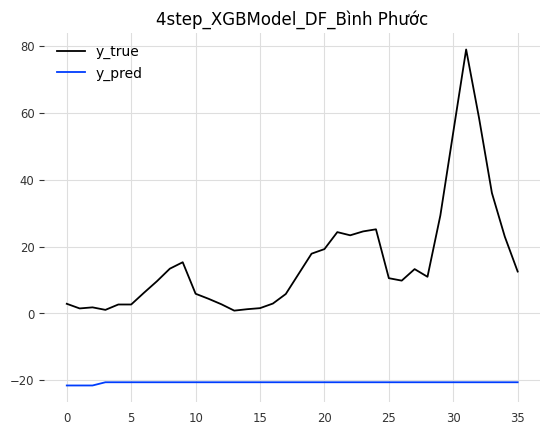

rmse,mae,mape,mse
40.36397902219954,36.431519396362596,5.884581441026143,1629.2508025045645
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,41.036587,1,6,"-4,-5,-6",1,14,quantile
1,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,37,quantile
2,Quảng Ninh,XGBModel,6.602554,1,6,"-4,-5,-6",1,3,quantile


mean_squared_error: 4442.0243
rmse: 66.64851297459367
mape: 7.933711740345583


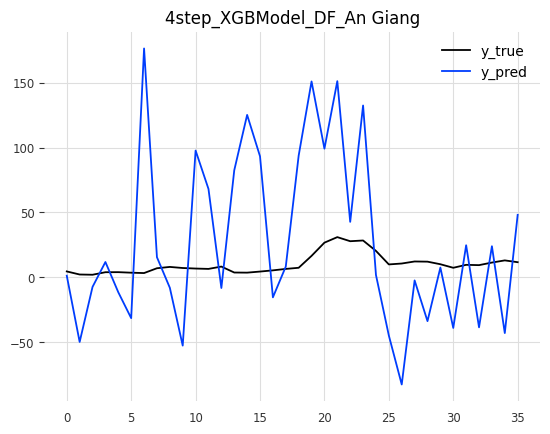

rmse,mae,mape,mse
66.64851297459367,51.07209476622929,7.933711740345583,4442.024281724581
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,41.036587,1,6,"-4,-5,-6",1,14,quantile
1,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,37,quantile
2,Quảng Ninh,XGBModel,6.602554,1,6,"-4,-5,-6",1,3,quantile


mean_squared_error: 35.7172
rmse: 5.976388529066655
mape: 6126020462845951.0


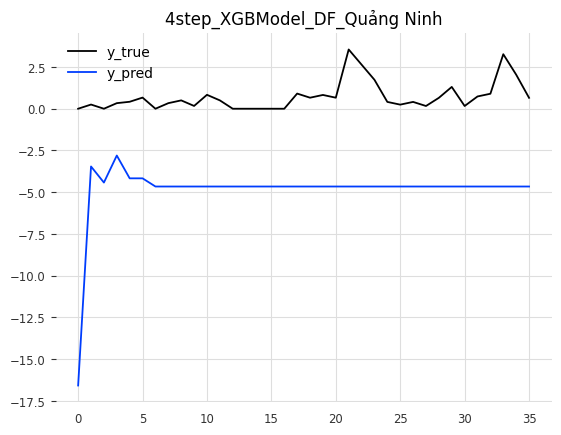

rmse,mae,mape,mse
5.976388529066655,5.593155562920811,6126020462845951.0,35.7172198503595
✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.314013,1,7,"-5,-6,-7",1,172,12,18
1,An Giang,RandomForest,11.226307,1,7,"-5,-6,-7",1,133,14,30
2,Quảng Ninh,RandomForest,5.496570,1,7,"-5,-6,-7",1,155,9,6


mean_squared_error: 306.2612
rmse: 17.500319353981347
mape: 2.040352031024218


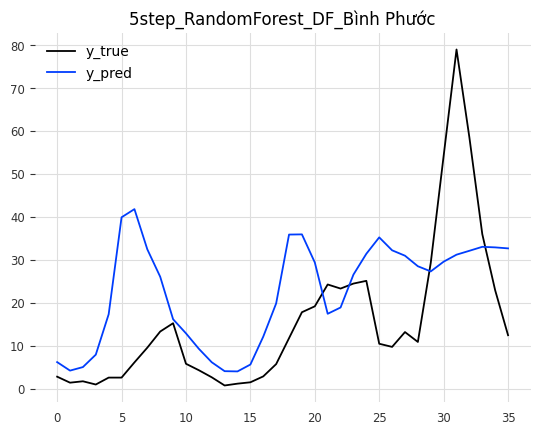

rmse,mae,mape,mse
17.500319353981347,13.292088284908296,2.040352031024218,306.26117749133414
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.314013,1,7,"-5,-6,-7",1,172,12,18
1,An Giang,RandomForest,11.226307,1,7,"-5,-6,-7",1,133,14,30
2,Quảng Ninh,RandomForest,5.496570,1,7,"-5,-6,-7",1,155,9,6


mean_squared_error: 102.9399
rmse: 10.14593044597774
mape: 1.6132046164692424


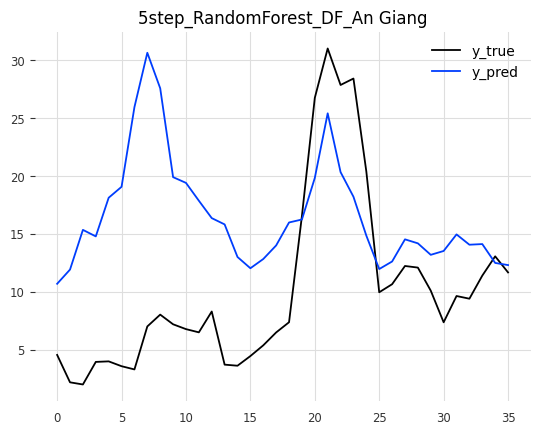

rmse,mae,mape,mse
10.14593044597774,8.345184792093374,1.6132046164692424,102.93990461461804
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.314013,1,7,"-5,-6,-7",1,172,12,18
1,An Giang,RandomForest,11.226307,1,7,"-5,-6,-7",1,133,14,30
2,Quảng Ninh,RandomForest,5.496570,1,7,"-5,-6,-7",1,155,9,6


mean_squared_error: 31.6564
rmse: 5.626406183519481
mape: 5225922166155107.0


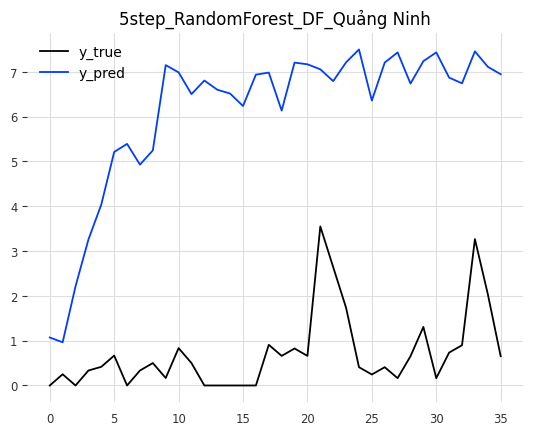

rmse,mae,mape,mse
5.626406183519481,5.381418194487553,5225922166155107.0,31.656446541946245
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,19.908115,1,7,"-5,-6,-7",1,3
1,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,15
2,Quảng Ninh,LinearRegressionModel,2.038829,1,7,"-5,-6,-7",1,7


mean_squared_error: 347.6714
rmse: 18.645947787224944
mape: 4.394185092588003


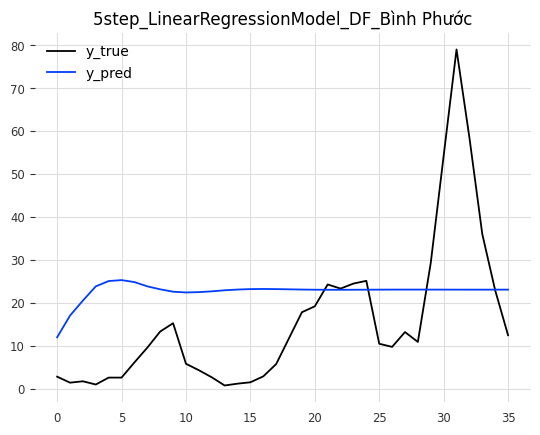

rmse,mae,mape,mse
18.645947787224944,15.161426308129194,4.394185092588003,347.6713688839188
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,19.908115,1,7,"-5,-6,-7",1,3
1,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,15
2,Quảng Ninh,LinearRegressionModel,2.038829,1,7,"-5,-6,-7",1,7


mean_squared_error: 155.8036
rmse: 12.482130315448206
mape: 1.7307355461402052


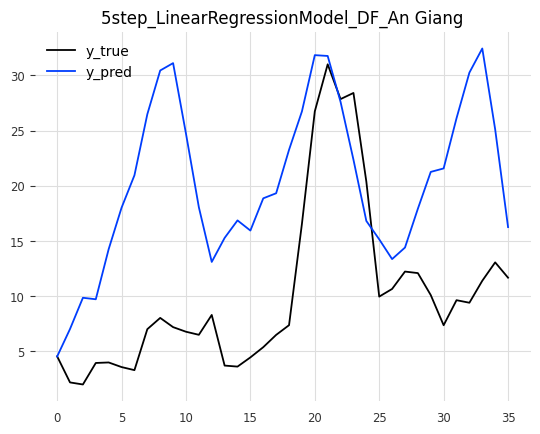

rmse,mae,mape,mse
12.482130315448206,10.599352955078263,1.7307355461402052,155.8035772118311
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,19.908115,1,7,"-5,-6,-7",1,3
1,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,15
2,Quảng Ninh,LinearRegressionModel,2.038829,1,7,"-5,-6,-7",1,7


mean_squared_error: 2.6195
rmse: 1.6184901503935063
mape: 2051199492640355.5


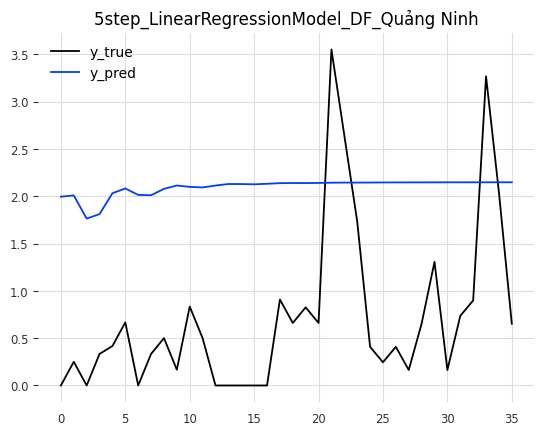

rmse,mae,mape,mse
1.6184901503935063,1.543883107433345,2051199492640355.5,2.6195103669207946
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.451480,1,7,"-5,-6,-7",1,0.061236,124,12,508,quantile,IsNone,99.599786,129,2.745961,8.965655
1,An Giang,CatBoost,8.092006,1,7,"-5,-6,-7",1,0.046877,111,4,78,quantile,"0.1,0.5,0.9",19.696183,93,6.399986,1.884949
2,Quảng Ninh,CatBoost,4.206923,1,7,"-5,-6,-7",1,0.021551,167,9,401,quantile,"0.1,0.5,0.9",31.041980,134,7.464033,4.796969


mean_squared_error: 614.6188
rmse: 24.79150578618718
mape: 2.000029544467292


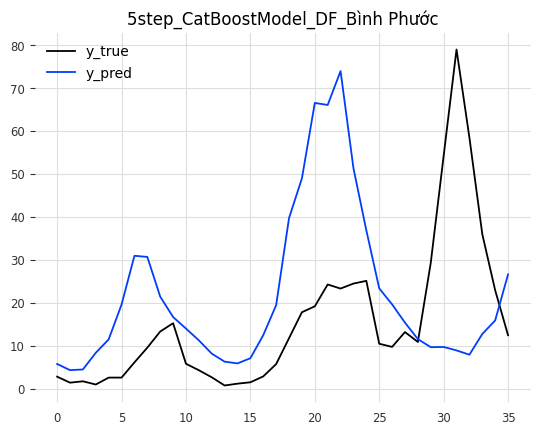

rmse,mae,mape,mse
24.79150578618718,18.038069036288405,2.000029544467292,614.6187591465525
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.451480,1,7,"-5,-6,-7",1,0.061236,124,12,508,quantile,IsNone,99.599786,129,2.745961,8.965655
1,An Giang,CatBoost,8.092006,1,7,"-5,-6,-7",1,0.046877,111,4,78,quantile,"0.1,0.5,0.9",19.696183,93,6.399986,1.884949
2,Quảng Ninh,CatBoost,4.206923,1,7,"-5,-6,-7",1,0.021551,167,9,401,quantile,"0.1,0.5,0.9",31.041980,134,7.464033,4.796969


🔥 1    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 47.5898
rmse: 6.898537633512458
mape: 0.8350031090372129


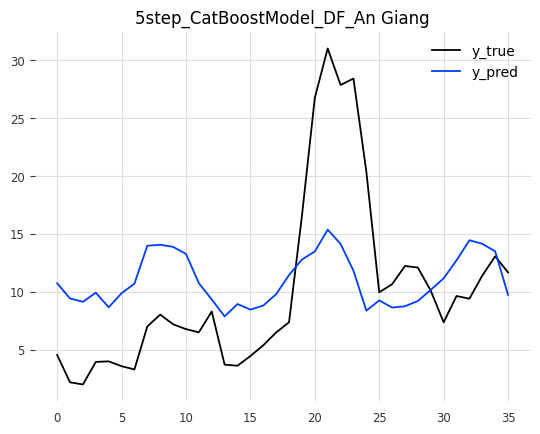

rmse,mae,mape,mse
6.898537633512458,5.605734390316603,0.8350031090372129,47.589821480987666
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.451480,1,7,"-5,-6,-7",1,0.061236,124,12,508,quantile,IsNone,99.599786,129,2.745961,8.965655
1,An Giang,CatBoost,8.092006,1,7,"-5,-6,-7",1,0.046877,111,4,78,quantile,"0.1,0.5,0.9",19.696183,93,6.399986,1.884949
2,Quảng Ninh,CatBoost,4.206923,1,7,"-5,-6,-7",1,0.021551,167,9,401,quantile,"0.1,0.5,0.9",31.041980,134,7.464033,4.796969


🔥 2    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 20.9721
rmse: 4.5795275188833555
mape: 4634988499902115.0


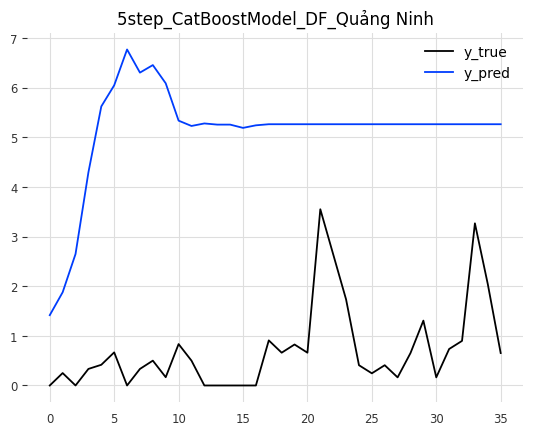

rmse,mae,mape,mse
4.5795275188833555,4.398833450411815,4634988499902115.0,20.972072296209944
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,50.281828,1,7,"-5,-6,-7",1,43,quantile
1,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,26,quantile
2,Quảng Ninh,XGBModel,4.394113,1,7,"-5,-6,-7",1,9,quantile


mean_squared_error: 933.5903
rmse: 30.554709291141204
mape: 7.942993021370302


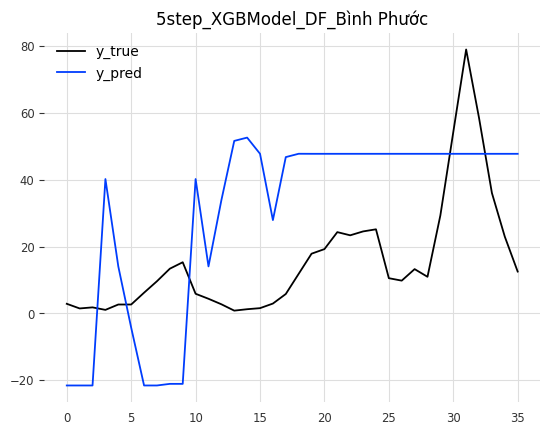

rmse,mae,mape,mse
30.554709291141204,28.370233665206023,7.942993021370302,933.5902598661507
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,50.281828,1,7,"-5,-6,-7",1,43,quantile
1,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,26,quantile
2,Quảng Ninh,XGBModel,4.394113,1,7,"-5,-6,-7",1,9,quantile


mean_squared_error: 1778.1888
rmse: 42.16857575766047
mape: 4.732498209924145


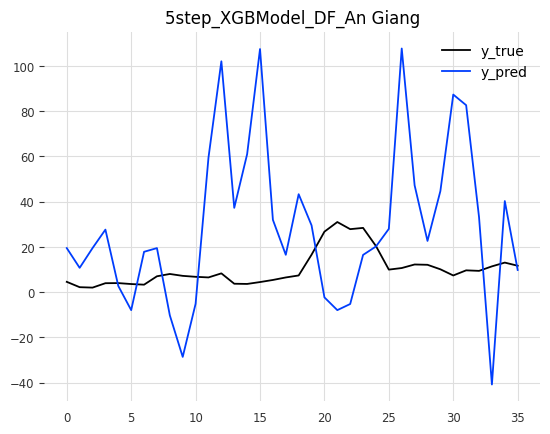

rmse,mae,mape,mse
42.16857575766047,32.32510303851208,4.732498209924145,1778.1887814295505
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,50.281828,1,7,"-5,-6,-7",1,43,quantile
1,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,26,quantile
2,Quảng Ninh,XGBModel,4.394113,1,7,"-5,-6,-7",1,9,quantile


mean_squared_error: 27.9582
rmse: 5.287549684335864
mape: 5082637609379513.0


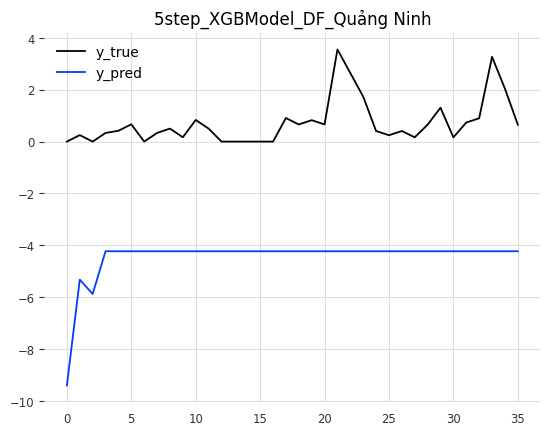

rmse,mae,mape,mse
5.287549684335864,5.166132721846862,5082637609379513.0,27.958181664320293
✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,20.463666,1,8,"-6,-7,-8",1,166,5,36
1,An Giang,RandomForest,24.997098,1,8,"-6,-7,-8",1,153,14,36
2,Quảng Ninh,RandomForest,5.975027,1,8,"-6,-7,-8",1,73,10,4


mean_squared_error: 368.1064
rmse: 19.186099287507396
mape: 1.5245321119856206


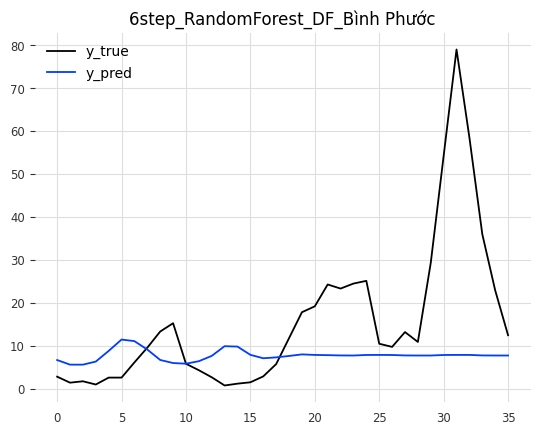

rmse,mae,mape,mse
19.186099287507396,12.020931309757126,1.5245321119856206,368.10640587009186
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,20.463666,1,8,"-6,-7,-8",1,166,5,36
1,An Giang,RandomForest,24.997098,1,8,"-6,-7,-8",1,153,14,36
2,Quảng Ninh,RandomForest,5.975027,1,8,"-6,-7,-8",1,73,10,4


mean_squared_error: 77.4750
rmse: 8.801991054576227
mape: 1.300902642401553


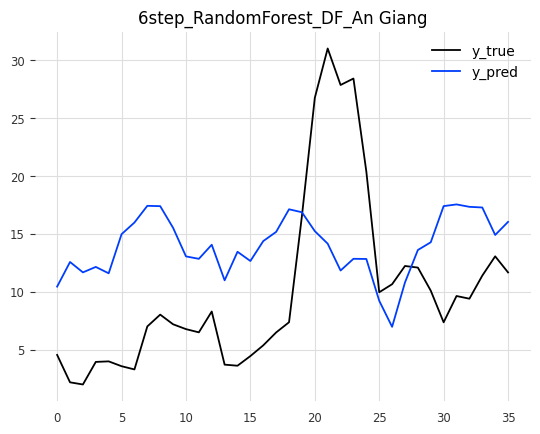

rmse,mae,mape,mse
8.801991054576227,7.842431607912336,1.300902642401553,77.47504652483993
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,20.463666,1,8,"-6,-7,-8",1,166,5,36
1,An Giang,RandomForest,24.997098,1,8,"-6,-7,-8",1,153,14,36
2,Quảng Ninh,RandomForest,5.975027,1,8,"-6,-7,-8",1,73,10,4


mean_squared_error: 28.7235
rmse: 5.359431446800294
mape: 1261095252447577.2


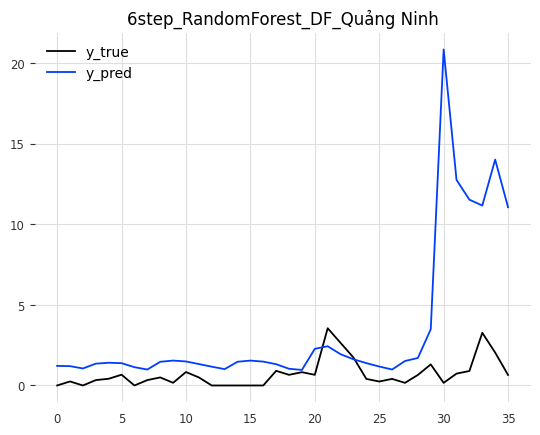

rmse,mae,mape,mse
5.359431446800294,2.8716167401743555,1261095252447577.2,28.723505432951892
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,19.644659,1,8,"-6,-7,-8",1,38
1,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,11
2,Quảng Ninh,LinearRegressionModel,2.017087,1,8,"-6,-7,-8",1,3


mean_squared_error: 341.7236
rmse: 18.48576879741873
mape: 4.292303363459206


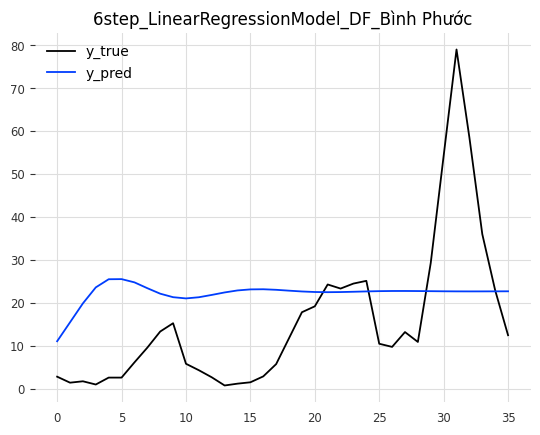

rmse,mae,mape,mse
18.48576879741873,14.914180375200509,4.292303363459206,341.72364803161986
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,19.644659,1,8,"-6,-7,-8",1,38
1,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,11
2,Quảng Ninh,LinearRegressionModel,2.017087,1,8,"-6,-7,-8",1,3


mean_squared_error: 164.5409
rmse: 12.827349620781282
mape: 1.7705520705528868


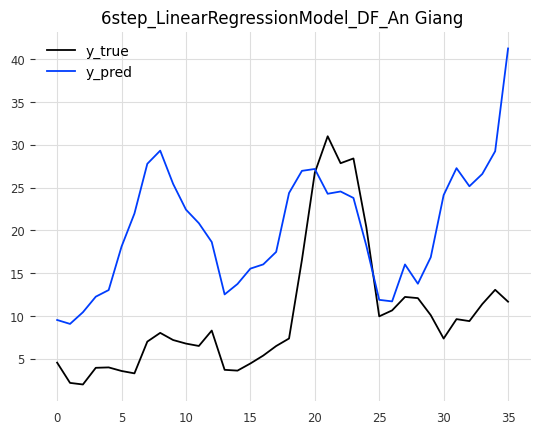

rmse,mae,mape,mse
12.827349620781282,10.950017987954766,1.7705520705528868,164.54089829375772
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,19.644659,1,8,"-6,-7,-8",1,38
1,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,11
2,Quảng Ninh,LinearRegressionModel,2.017087,1,8,"-6,-7,-8",1,3


mean_squared_error: 2.5860
rmse: 1.6081076141232937
mape: 2044978839506601.0


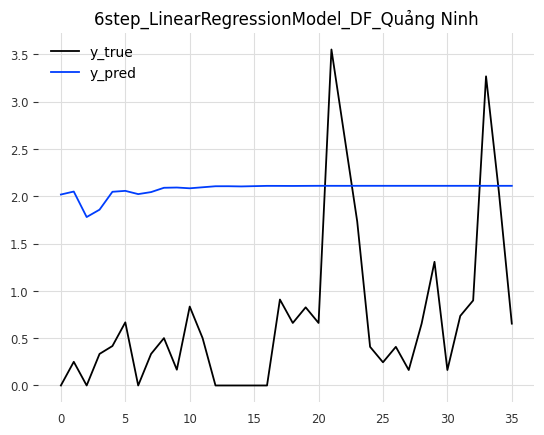

rmse,mae,mape,mse
1.6081076141232937,1.5324738604395272,2044978839506601.0,2.5860100986013124
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,22.381411,1,8,"-6,-7,-8",1,0.034895,108,10,880,quantile,IsNone,8.708441,177,8.064460,7.325637
1,An Giang,CatBoost,11.214762,1,8,"-6,-7,-8",1,0.060910,162,11,147,quantile,"0.1,0.5,0.9",79.447285,137,1.060691,4.883597
2,Quảng Ninh,CatBoost,5.632298,1,8,"-6,-7,-8",1,0.069629,62,7,773,quantile,"0.1,0.5,0.9",81.893665,30,8.907960,6.015434


mean_squared_error: 739.3860
rmse: 27.191654031150804
mape: 6.232948283546238


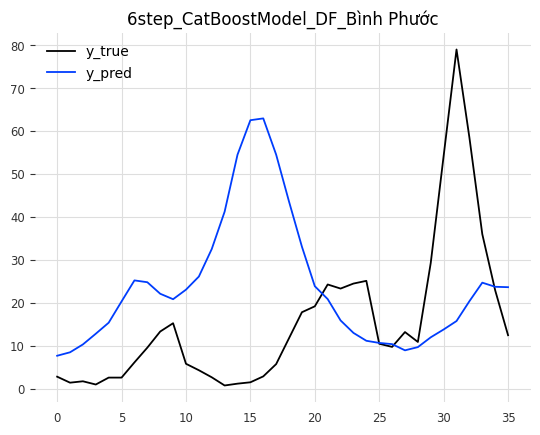

rmse,mae,mape,mse
27.191654031150804,20.013640187250925,6.232948283546238,739.3860489497997
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,22.381411,1,8,"-6,-7,-8",1,0.034895,108,10,880,quantile,IsNone,8.708441,177,8.064460,7.325637
1,An Giang,CatBoost,11.214762,1,8,"-6,-7,-8",1,0.060910,162,11,147,quantile,"0.1,0.5,0.9",79.447285,137,1.060691,4.883597
2,Quảng Ninh,CatBoost,5.632298,1,8,"-6,-7,-8",1,0.069629,62,7,773,quantile,"0.1,0.5,0.9",81.893665,30,8.907960,6.015434


🔥 1    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 141.6605
rmse: 11.902122370665074
mape: 1.6069581852563313


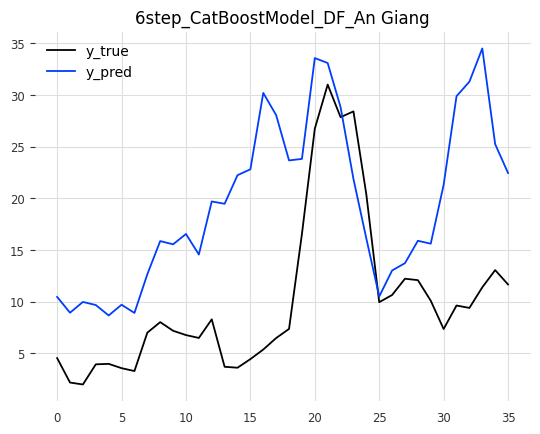

rmse,mae,mape,mse
11.902122370665074,9.809325765718377,1.6069581852563313,141.660516926286
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,22.381411,1,8,"-6,-7,-8",1,0.034895,108,10,880,quantile,IsNone,8.708441,177,8.064460,7.325637
1,An Giang,CatBoost,11.214762,1,8,"-6,-7,-8",1,0.060910,162,11,147,quantile,"0.1,0.5,0.9",79.447285,137,1.060691,4.883597
2,Quảng Ninh,CatBoost,5.632298,1,8,"-6,-7,-8",1,0.069629,62,7,773,quantile,"0.1,0.5,0.9",81.893665,30,8.907960,6.015434


🔥 2    0.1,0.5,0.9
Name: quantiles, dtype: object - <class 'pandas.core.series.Series'>
💧 0.1,0.5,0.9 - <class 'str'>
mean_squared_error: 20.6033
rmse: 4.539084634017563
mape: 5246703865467810.0


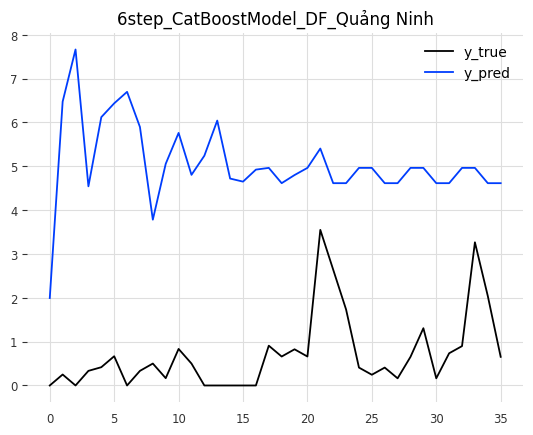

rmse,mae,mape,mse
4.539084634017563,4.343137636767599,5246703865467810.0,20.60328931477435
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,53.563692,1,8,"-6,-7,-8",1,41,quantile
1,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,39,quantile
2,Quảng Ninh,XGBModel,5.613010,1,8,"-6,-7,-8",1,25,quantile


mean_squared_error: 1600.7460
rmse: 40.00932329337439
mape: 6.8963279145545435


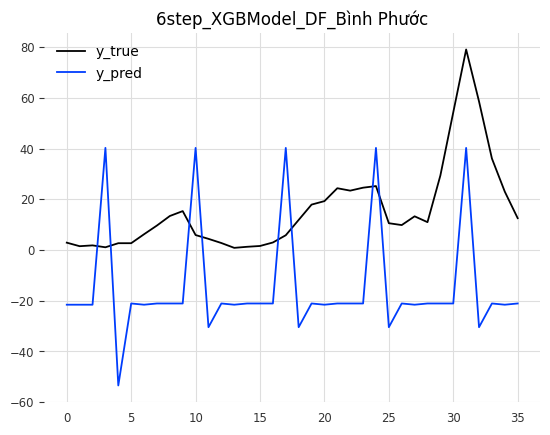

rmse,mae,mape,mse
40.00932329337439,37.18578312242929,6.8963279145545435,1600.7459503937507
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,53.563692,1,8,"-6,-7,-8",1,41,quantile
1,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,39,quantile
2,Quảng Ninh,XGBModel,5.613010,1,8,"-6,-7,-8",1,25,quantile


mean_squared_error: 2199.5466
rmse: 46.899323628193144
mape: 6.143344982536135


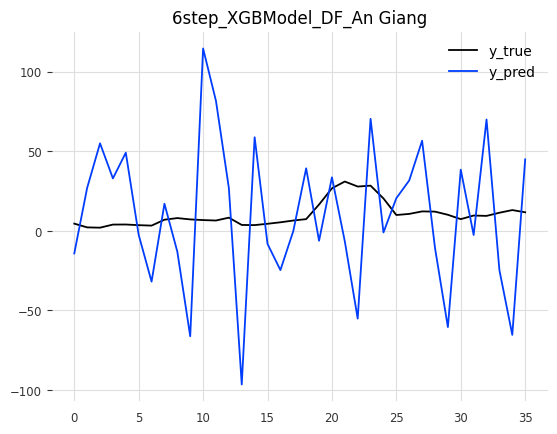

rmse,mae,mape,mse
46.899323628193144,38.60241573587473,6.143344982536135,2199.546556781996
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,53.563692,1,8,"-6,-7,-8",1,41,quantile
1,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,39,quantile
2,Quảng Ninh,XGBModel,5.613010,1,8,"-6,-7,-8",1,25,quantile


mean_squared_error: 6.4909
rmse: 2.5477238658148424
mape: 1858591952666459.0


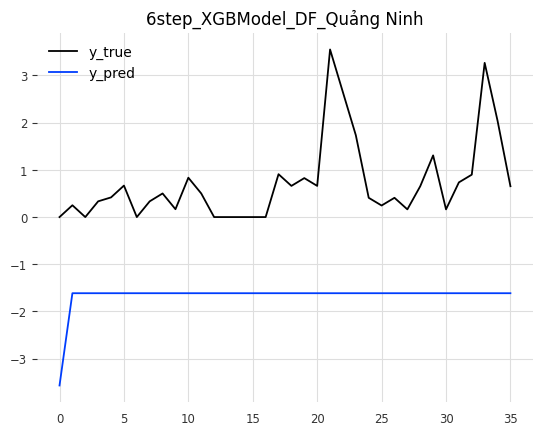

rmse,mae,mape,mse
2.5477238658148424,2.3872287020248564,1858591952666459.0,6.490896896442526


In [17]:
model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
    #  "LightGBMModel",
     "CatBoostModel",
     "XGBModel",
    # "PoissonRegressor",
    # "SVMRBF"
]

for nstep in range(1,args.n_predicted_period_months+1):
# for nstep in range(1,2):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state),
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state))
            elif model_name == "CatBoostModel":
                    
                    
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    opt_quantitles = df_hyper_params['quantiles'].values[0]
                    if opt_quantitles == "IsNone":
                        quantitles = None
                    else:
                        print("🔥",df_hyper_params['quantiles'], "-", type(df_hyper_params['quantiles']))
                        print("💧",df_hyper_params['quantiles'].values[0],  "-", type(df_hyper_params['quantiles'].values[0]))
                        quantitles = df_hyper_params['quantiles'].values[0].split(',')
                    model = CatBoostModel(
                                            lags=int(lags),
                                            lags_past_covariates=lags_past_covariates, 
                                            learning_rate=float(learning_rate),
                                            n_estimators= int(n_estimators),
                                            max_depth=int(max_depth), 
                                            output_chunk_length = int(output_chunk_length),
                                            likelihood = likelihood,
                                            # quantiles = float(quantiles), #None or float
                                            bagging_temperature = float(bagging_temperature),
                                            # border_count = int(border_count),
                                            l2_leaf_reg = float(l2_leaf_reg),
                                            random_strength = float(random_strength),
                                            random_state=int(random_state))
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    bagging_fraction = df_hyper_params['bagging_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    verbose = df_hyper_params['verbose'].values[0]
                    model = LightGBMModel(
                        lags =int(lags),
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = int(output_chunk_length),
                        random_state = int(random_state),
                        multi_models = bool(multi_models),
                        likelihood = likelihood,
                        num_leaves = int(num_leaves),
                        learning_rate = float(learning_rate),
                        feature_fraction = float(feature_fraction),
                        bagging_fraction = float(bagging_fraction),
                        min_child_samples = int(min_child_samples),
                        lambda_l1 = float(lambda_l1),
                        verbose = int(verbose)
                    )          
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo, nstep = nstep)
            df.to_excel(f"./predict_results/0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"./trained_models/{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))